In [2]:
!pip install umap-learn
!pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 844.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00


**Imports and global settings**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

## EDA:

This dataset provides a comprehensive record of Apple Inc.'s stock price changes over the past 44 years. It includes essential columns such as the date, opening price, highest price of the day, lowest price of the day, closing price, adjusted closing price, and trading volume.

https://www.kaggle.com/datasets/mayankanand2701/apple-stock-price-dataset

**Reading in the dataset**

In [4]:
# prompt: i have this ulr path to my csv https://drive.google.com/file/d/19VADLkrT6HD_98vlsar1y5s0OHZMCIBf/view?usp=drive_link,  how could i load it?

import pandas as pd

url = 'https://drive.google.com/file/d/19VADLkrT6HD_98vlsar1y5s0OHZMCIBf/view?usp=drive_link'

# Get the ID from the URL
file_id = url.split('/')[-2]

# Download the file from Google Drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='{file_id} -O apple_stock.csv

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('apple_stock.csv')
df.head()

--2024-06-20 11:40:40--  https://docs.google.com/uc?export=download&id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf
Resolving docs.google.com (docs.google.com)... 142.251.183.102, 142.251.183.113, 142.251.183.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.183.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf&export=download [following]
--2024-06-20 11:40:40--  https://drive.usercontent.google.com/download?id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.206.132, 2607:f8b0:4001:c62::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.206.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743226 (726K) [application/octet-stream]
Saving to: ‘apple_stock.csv’

apple_stock.csv     100%[===================>] 725.81K  --.-KB/

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10954 non-null  object 
 1   Open       10954 non-null  float64
 2   High       10954 non-null  float64
 3   Low        10954 non-null  float64
 4   Close      10954 non-null  float64
 5   Adj Close  10954 non-null  float64
 6   Volume     10954 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 599.2+ KB


**Any duplicate rows?**

In [6]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**Checking data types**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10954 non-null  object 
 1   Open       10954 non-null  float64
 2   High       10954 non-null  float64
 3   Low        10954 non-null  float64
 4   Close      10954 non-null  float64
 5   Adj Close  10954 non-null  float64
 6   Volume     10954 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 599.2+ KB


In [9]:
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = df['Date'].apply(lambda x: x.toordinal())

**Cleaning up column names (mainly for handling purposes)**

In [10]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,date,open,high,low,close,adj close,volume,date_numeric
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600,723161
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800,723164
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000,723165
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600,723166
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600,723167


**Quick overview over the individual distributions**

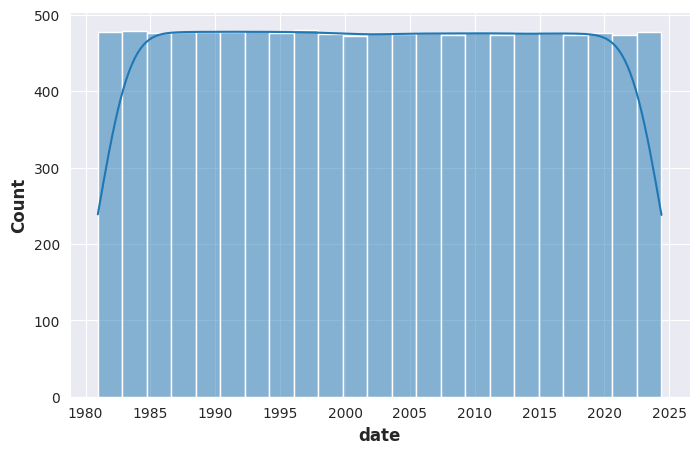

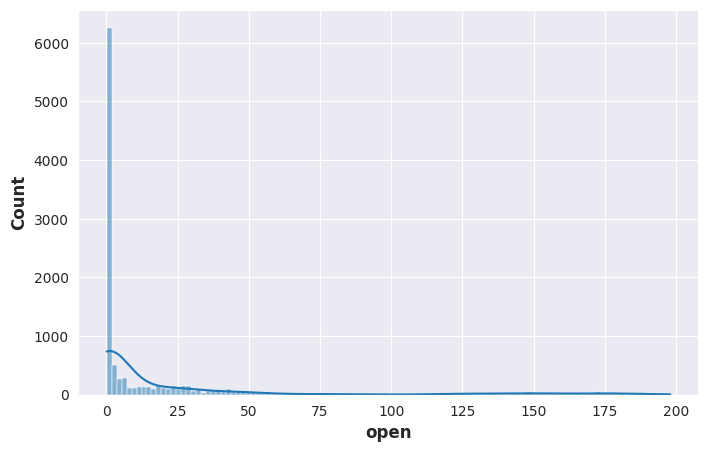

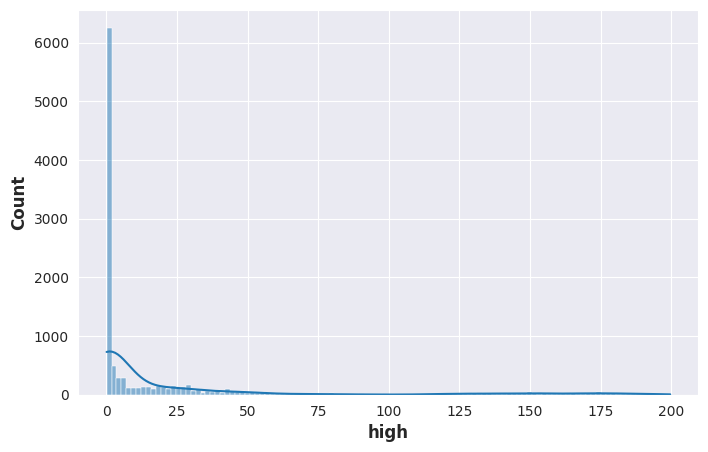

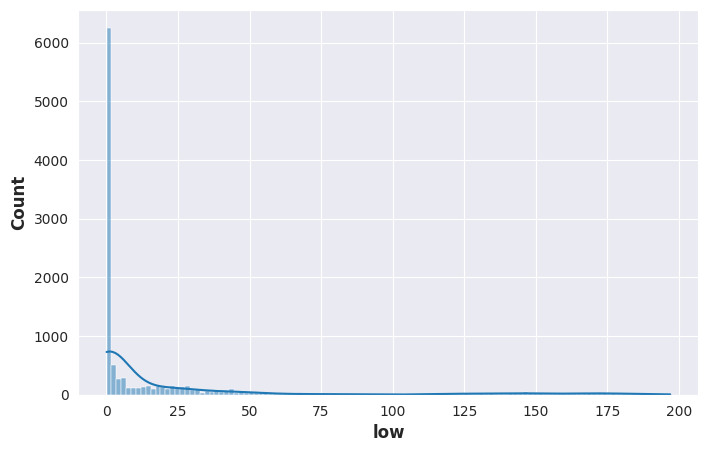

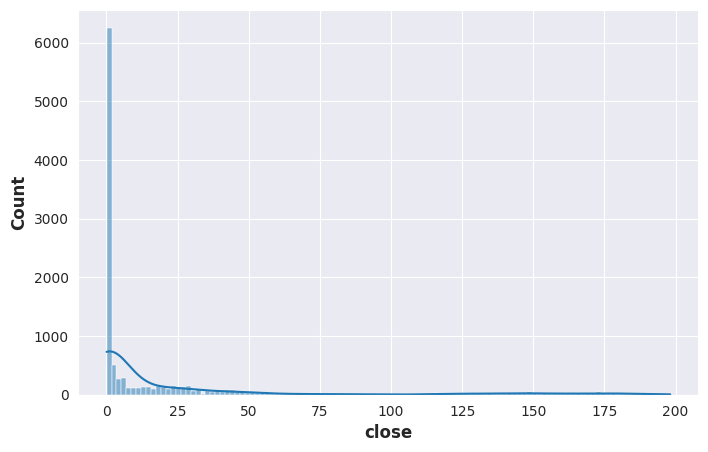

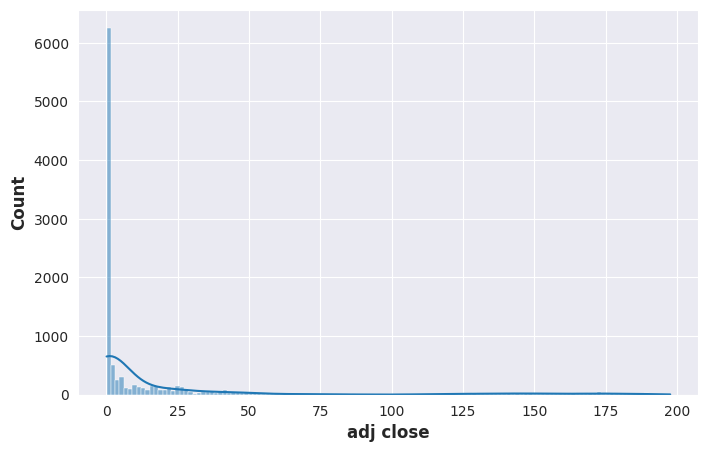

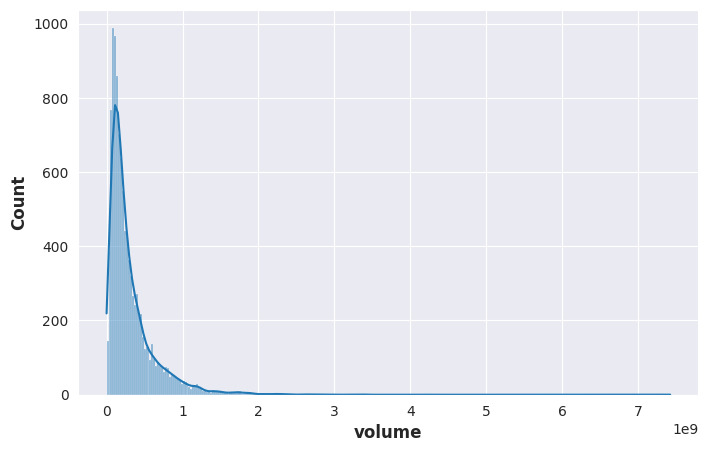

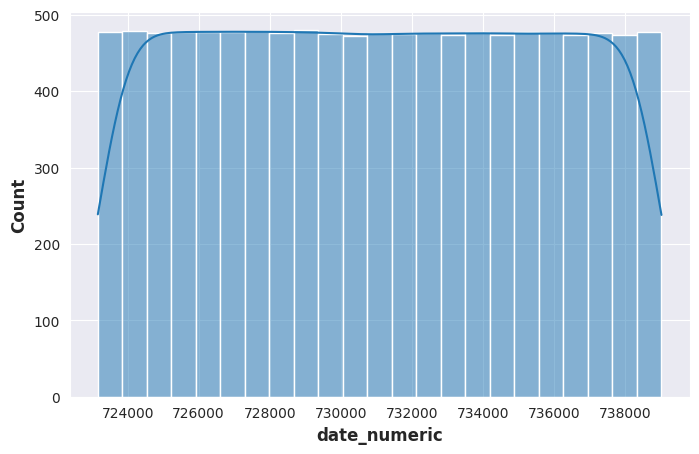

In [11]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

In [12]:
df = df.drop(columns=['date'])
df.head()

,open,high,low,close,adj close,volume,date_numeric
0,0.128348,0.128906,0.128348,0.128348,0.099058,469033600,723161
1,0.122210,0.122210,0.121652,0.121652,0.093890,175884800,723164
2,0.113281,0.113281,0.112723,0.112723,0.086999,105728000,723165
3,0.115513,0.116071,0.115513,0.115513,0.089152,86441600,723166
4,0.118862,0.119420,0.118862,0.118862,0.091737,73449600,723167


# Clustering

In [80]:
# algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]
algos = ["K-means", "Mean shift", "Gaussian mixtures", "DBSCAN"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [81]:
X = StandardScaler().fit_transform(df)

In [82]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [83]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,open,high,low,close,adj close,volume,date_numeric
0,-0.933391,-0.933808,-0.932904,-0.933384,-0.921268,0.335564,-1.732369
1,-0.933825,-0.934276,-0.933382,-0.933856,-0.921645,-0.575315,-1.731712
2,-0.934455,-0.934900,-0.934019,-0.934487,-0.922147,-0.975955,-1.731494
3,-0.934298,-0.934705,-0.933820,-0.934290,-0.921990,-1.100981,-1.731275
4,-0.934061,-0.934471,-0.933581,-0.934053,-0.921802,-1.188942,-1.731056


## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 7 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [84]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

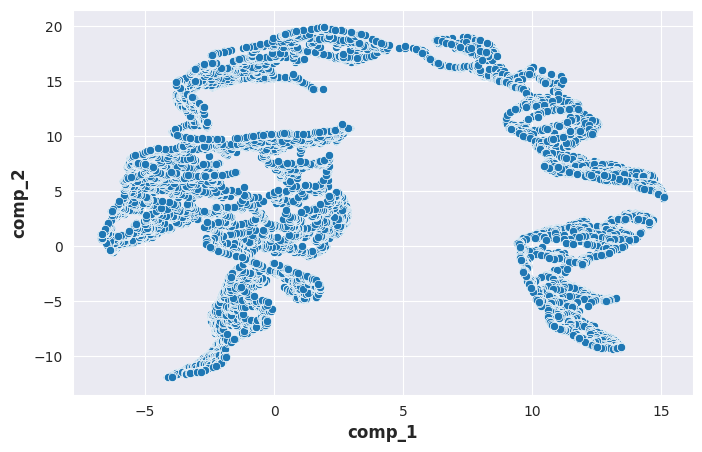

In [85]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [86]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [87]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [88]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

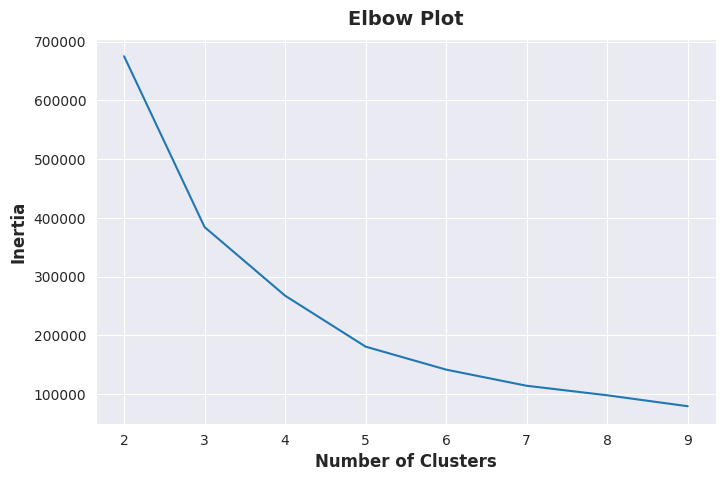

In [89]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> Salient "kink" at 3 clusters. This is thus the number of clusters to go for. As discussed above, this is along the lines of what is to be expected by just looking at the data. [3, 5] clusters

### Run with optimised *n_clusters*

3 clusters

In [90]:
%%time

clusters = 3
start_time = time.time()

kmeans = KMeans(n_clusters=clusters, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

# training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 5, max_iter: 300

CPU times: user 164 ms, sys: 6.9 ms, total: 171 ms
Wall time: 98.4 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


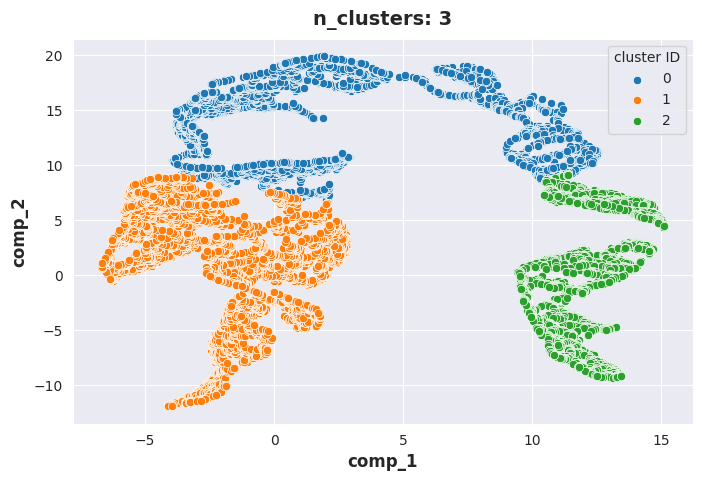

In [91]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=clusters, noise_exist=False)


5 clusters

In [92]:
%%time

clusters = 5
start_time = time.time()

kmeans = KMeans(n_clusters=clusters, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 17, max_iter: 300

CPU times: user 265 ms, sys: 2.02 ms, total: 267 ms
Wall time: 150 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


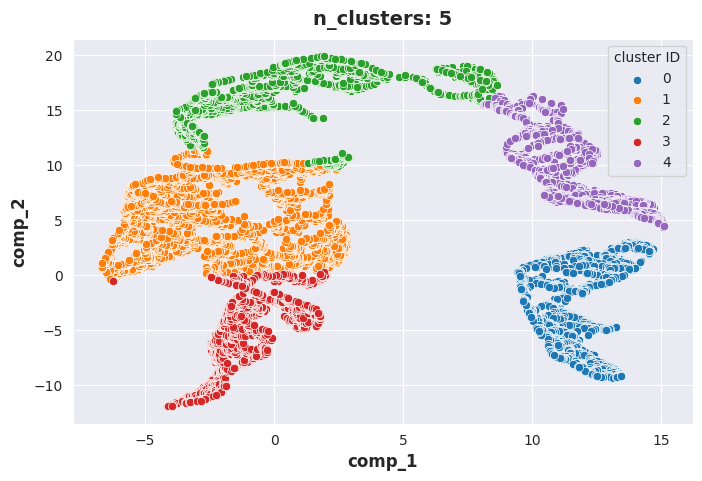

In [93]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=clusters, noise_exist=False)

## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [94]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [95]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 39, max_iter: 300

CPU times: user 15.2 s, sys: 691 ms, total: 15.9 s
Wall time: 2min 26s


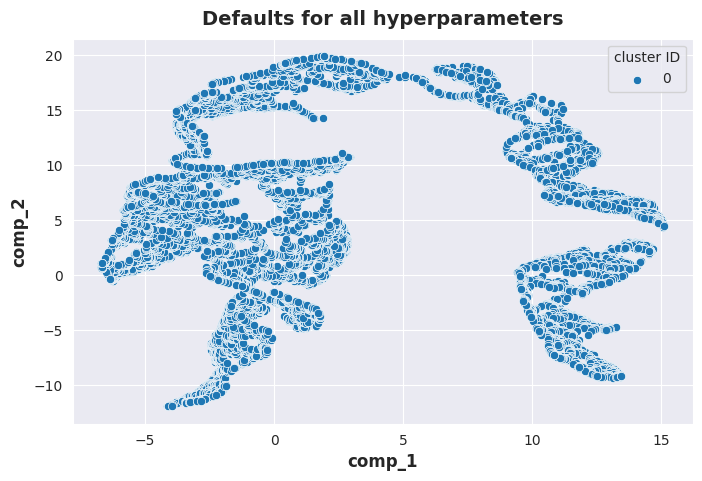

In [96]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [97]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 39, max_iter: 300

CPU times: user 14.7 s, sys: 645 ms, total: 15.3 s
Wall time: 2min 15s


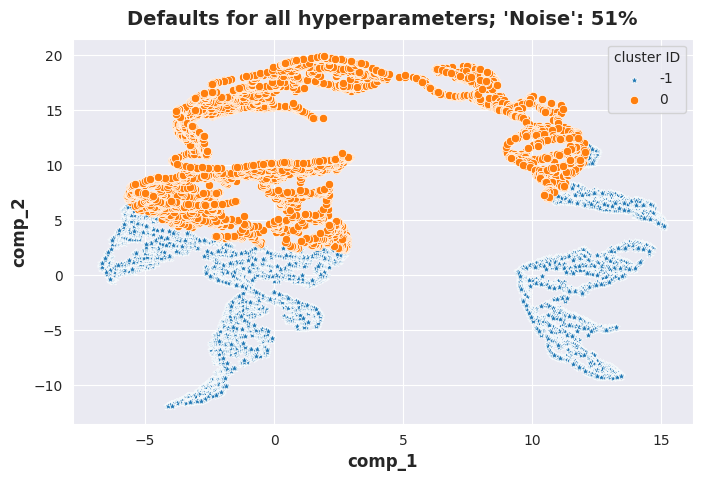

In [98]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 49%. bad

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [99]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [100]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 14, max_iter: 100

CPU times: user 172 ms, sys: 120 ms, total: 291 ms
Wall time: 176 ms


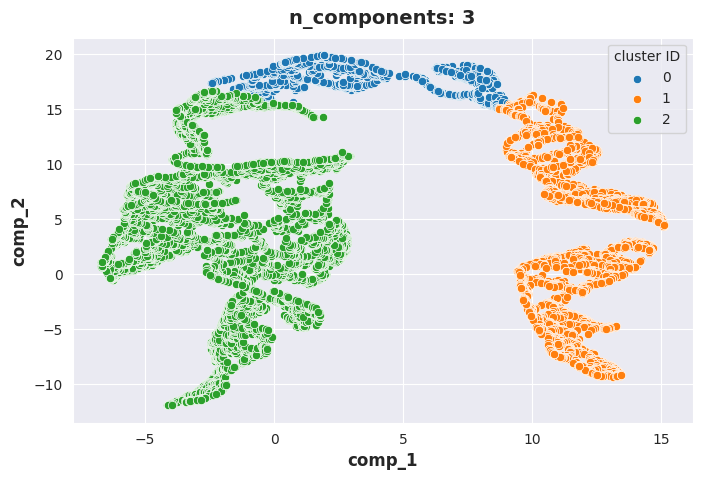

In [101]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [35]:
### Too much time calculating

# hyperparamter to tune

# affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
### Too much time calculating

# %%time

# affprop = AffinityPropagation(random_state=fixed_random_state)

# labels_4 = affprop.fit_predict(X)

# convergence_check(affprop)

In [ ]:
### Too much time calculating visualitation more than 2:30 hours

# visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

In [ ]:
### Too much time calculating visualitation more than 2:30 hours

# %%time

# damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

# for d in damps:
#     affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
#     labels_4 = affprop.fit_predict(X)
#     visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
#     convergence_check(affprop)

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [36]:
### Too much time calculating
# hyperparamter to tune

# affprop_hparam = "preference"

In [ ]:
### Too much time calculating

# %%time

# prefs = [-10, -25, -50, -75, -100]

# for p in prefs:
#     affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
#     labels_4 = affprop.fit_predict(X)
#     visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
#     convergence_check(affprop)

### Re-run with optimised *preference*

In [ ]:
### Too much time calculating

# %%time

# start_time = time.time()

# affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

# labels_4 = affprop.fit_predict(X)

# convergence_check(affprop)

# training_times.append(time.time() - start_time)

## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [102]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

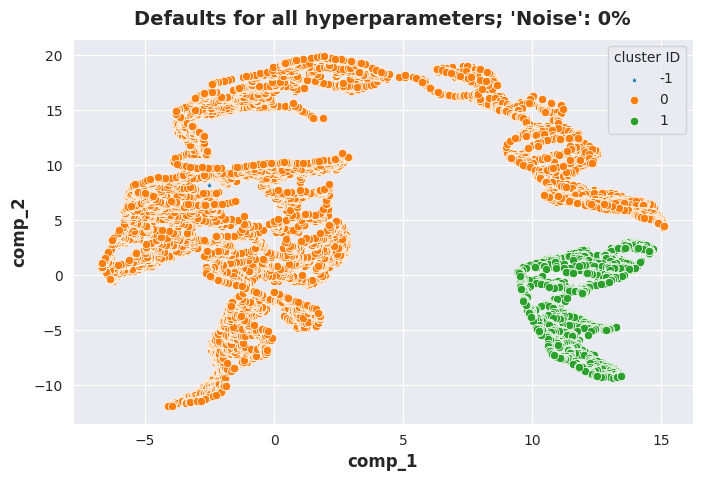

CPU times: user 828 ms, sys: 118 ms, total: 946 ms
Wall time: 804 ms


In [103]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 0%, meaning?

### Tuning runs for *eps*

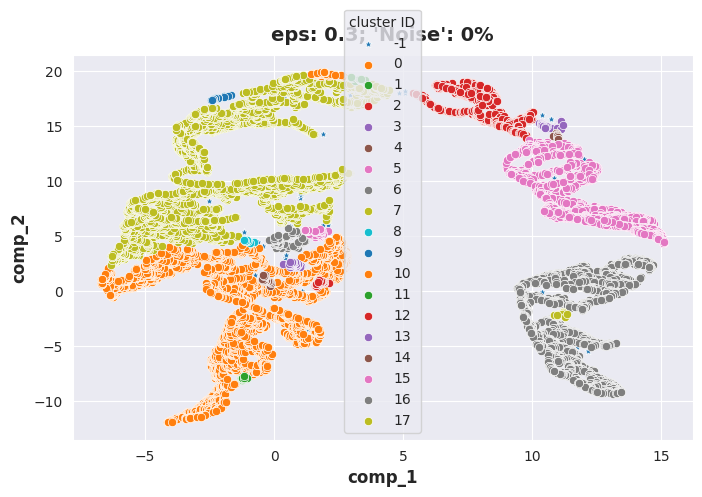

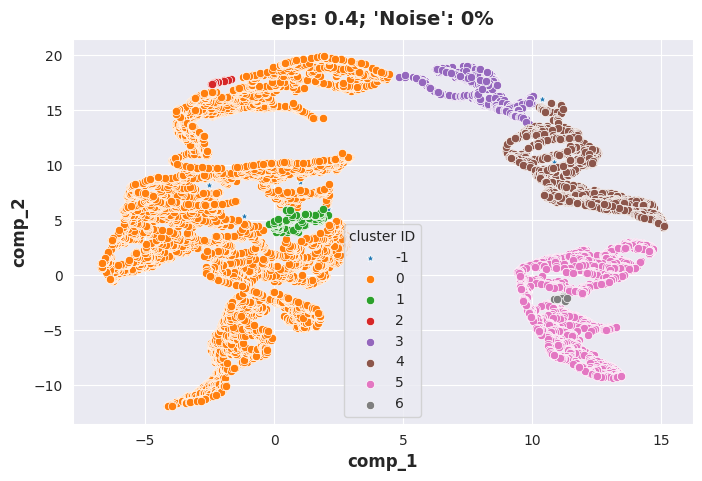

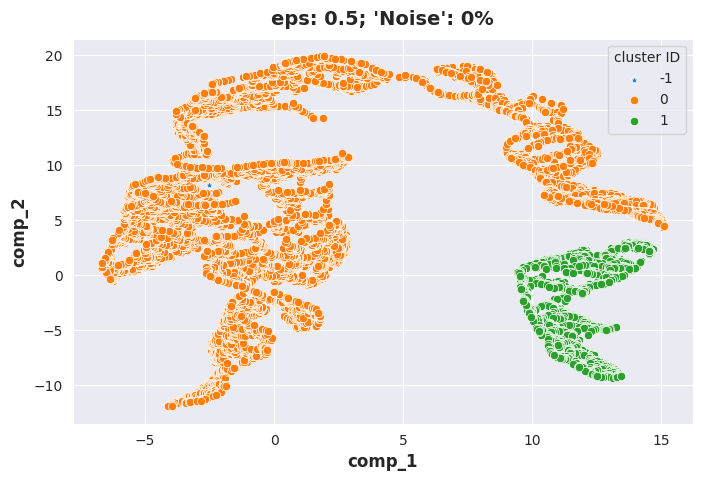

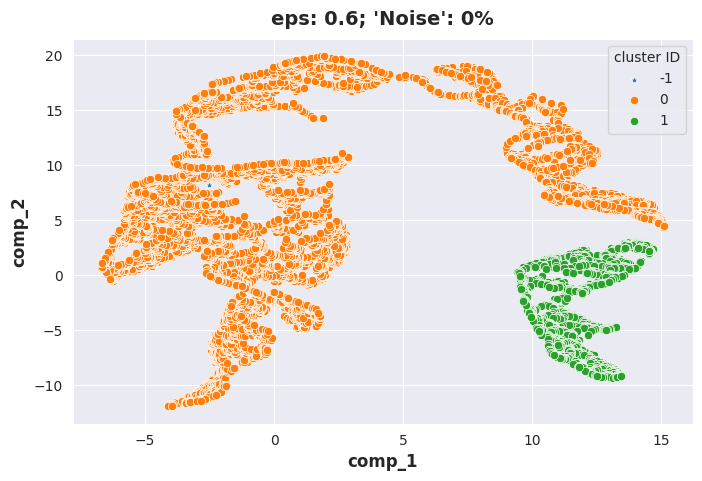

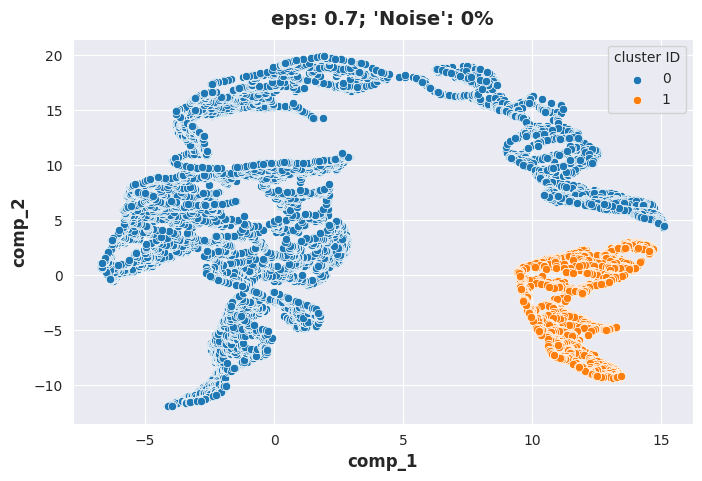

CPU times: user 6.12 s, sys: 375 ms, total: 6.5 s
Wall time: 6.4 s


In [104]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

Seems 0.5 is the best

### Re-run with optimised *eps*

In [105]:
%%time

eps_val = 0.5

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 131 ms, sys: 1.89 ms, total: 133 ms
Wall time: 92 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [42]:
### Too much time calculating

# hyperparamter to tune

# optics_hparam = "min_samples"

In [ ]:
### Too much time calculating

# %%time

# optics = OPTICS(n_jobs=n_parallel_jobs)

# labels_6 = optics.fit_predict(X)

# visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

In [ ]:
### Too much time calculating

# %%time

# for n_samples in [8, 12, 16, 20, 22]:

#     optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

#     labels_6 = optics.fit_predict(X)

#     visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

In [ ]:
### Too much time calculating

# %%time

# n_samples = 20

# start_time = time.time()

# optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

# labels_6 = optics.fit_predict(X)

# training_times.append(time.time() - start_time)

[0.1498560905456543, 135.87603855133057, 0.17561674118041992, 0.09196090698242188]


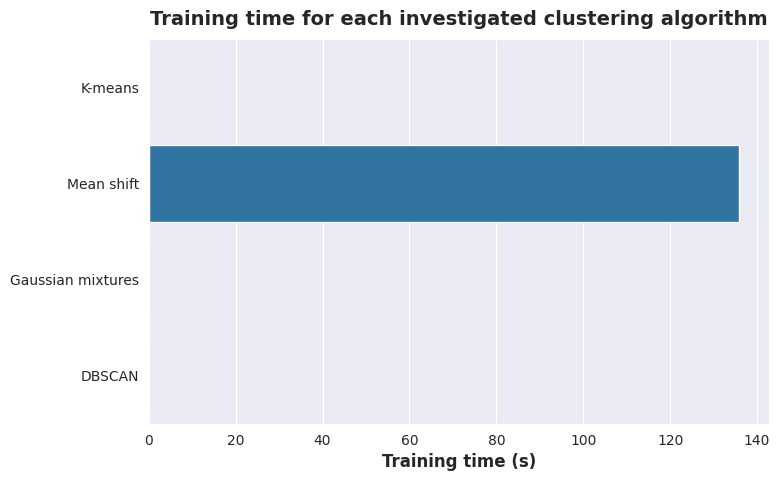

In [110]:
print(training_times)
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [108]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

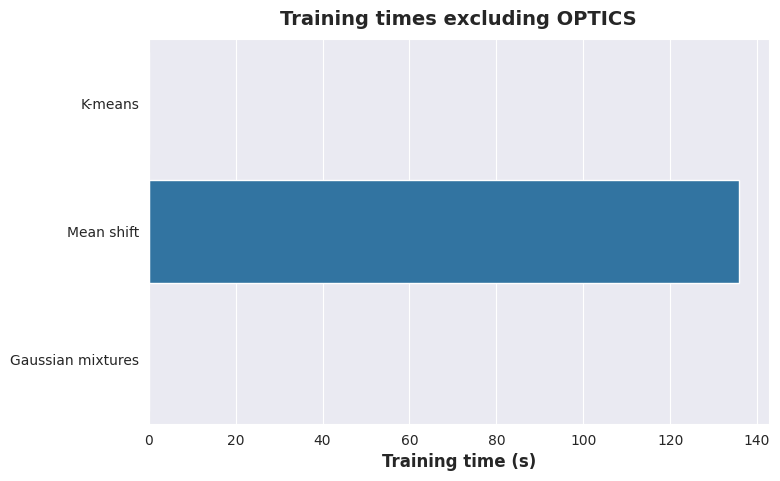

In [109]:
# overwriting the training time for Mean shift

plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()